# Classificação dos gêneros das músicas do spotify

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spotify = pd.read_csv('music_genre.csv')

A descrição das features pode ser encontrada em https://github.com/mateusdiaslima/spotify-prediction-task.

# Data cleaning

Como o instance_id identifica a música de forma única, verificamos se há valores duplicados para essa feature.

In [3]:
spotify[spotify['instance_id'].duplicated()]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A saída anterior mostra que os valores de instance_id duplicados são, na verdade, nulos. Então fazemos a remoção das linhas onde o instance_id é nulo.

In [4]:
spotify = spotify[~spotify['instance_id'].isna()]

É importante entender quais features podem ajudar na predição da feature de interesse (music_genre). As features instance_id, artist_name e track_name devem ser retiradas, pois é uma informação única para aquela música, ou seja, não é uma informação que podemos generalizar para outras músicas. Além disso, retiramos a feature obtained_date. Não encontramos nenhuma informação dessa feture, mas suspeitamos que refere-se a data que a música foi coletada.

In [5]:
spotify = spotify.drop(['instance_id','artist_name','track_name','obtained_date'], axis = 1)

Agora verificamos o tipo das variáveis. Isso é importante, pois devemos garantir que as features numéricas estejam como numéricas as features categóricas como categóricas.

In [6]:
spotify.dtypes

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object

A feature tempo é numérica. Precisamos entender porque ela veio como tipo object.

In [7]:
spotify['tempo'].sort_values()

28375    100.0
46597    100.0
38389    100.0
46815    100.0
14217    100.0
         ...  
43350        ?
10361        ?
42625        ?
17409        ?
46955        ?
Name: tempo, Length: 50000, dtype: object

Na saída anterior há alguns valores com '?', indicando que não há informação de tempo para a respectiva música. Logo, tratamos '?' como valor faltante.

In [8]:
spotify['tempo'] = spotify['tempo'].replace('?', np.NaN)

In [9]:
spotify[['key','mode','music_genre']] = spotify[['key','mode','music_genre']].astype('category')
spotify[['tempo']] = spotify[['tempo']].astype('float')

spotify.dtypes

popularity           float64
acousticness         float64
danceability         float64
duration_ms          float64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
speechiness          float64
tempo                float64
valence              float64
music_genre         category
dtype: object

Tudo certo com o tipo das features! 

Nas explicações das features no github, temos os possíveis valores para todas as features. O próximo passo é verificar se há algumas observações com os valores fora do intervalo permitido pelas features.

In [10]:
spotify.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,45020.000000,50000.000000
mean,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.952961,0.456264
std,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,30.641701,0.247119
min,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,94.941500,0.257000
50%,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,119.879000,0.448000
75%,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,140.471250,0.648000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


A saída acima mostra algumas estatísticas sumárias para as features numéricas. A única feature que identificamos inconsistência é a duration_ms, pois há valores negativos e isso não faz sentido para uma feature que é, essencialmente, positiva. Para uma análise mais elaborada, mostramos na saída abaixo um resumo dos valores de duration_ms menor ou igual a zero.

In [11]:
spotify[spotify['duration_ms'] <= 0]['duration_ms'].describe()

count    4939.0
mean       -1.0
std         0.0
min        -1.0
25%        -1.0
50%        -1.0
75%        -1.0
max        -1.0
Name: duration_ms, dtype: float64

A saída anterior mostra que os valores de duration_ms que não são positivos recebem o valor -1, pois o mínimo é igual ao máximo. Isso sugere que as músicas que não tiveram a duração_ms armazenada receberam o valor -1. Logo, tratamos -1 como valor faltante.

In [12]:
spotify['duration_ms'] = spotify['duration_ms'].replace(-1, np.NaN)

In [13]:
spotify.describe(include = 'category')

,key,mode,music_genre
count,50000,50000,50000
unique,12,2,10
top,G,Major,Alternative
freq,5727,32099,5000


A saída acima mostra algumas estatísticas sumárias para as features categóricas. A partir dela não identificamos nenhuma inconsistência com as features numéricas.

Agora precisamos identificar quais features tem valores faltantes.

In [14]:
spotify.isna().any()

popularity          False
acousticness        False
danceability        False
duration_ms          True
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo                True
valence             False
music_genre         False
dtype: bool

In [15]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   popularity        50000 non-null  float64 
 1   acousticness      50000 non-null  float64 
 2   danceability      50000 non-null  float64 
 3   duration_ms       45061 non-null  float64 
 4   energy            50000 non-null  float64 
 5   instrumentalness  50000 non-null  float64 
 6   key               50000 non-null  category
 7   liveness          50000 non-null  float64 
 8   loudness          50000 non-null  float64 
 9   mode              50000 non-null  category
 10  speechiness       50000 non-null  float64 
 11  tempo             45020 non-null  float64 
 12  valence           50000 non-null  float64 
 13  music_genre       50000 non-null  category
dtypes: category(3), float64(11)
memory usage: 4.7 MB


As features com valores faltantes são: duration_ms e tempo. Como, aproximadamente, 10% são valores faltantes para as duas features, inputamos os valores faltantes com a média.

In [16]:
spotify = spotify.fillna(spotify.mean()[['duration_ms','tempo']])

Com as manipulações que fizemos até aqui, podemos partir para a análise exploratória.

# Análise exploratória

Antes de começar a análise vamos definir algumas nomenclaturas para facilitar o entendimento: a feature que queremos prever, ou classificar, chamamos de **variável resposta**, ou seja, music_genre é a variável resposta; as outras features chamamos de **preditoras**, pois são usadas para predizer a variável resposta.

### Análise das preditoras categóricas versus variável resposta

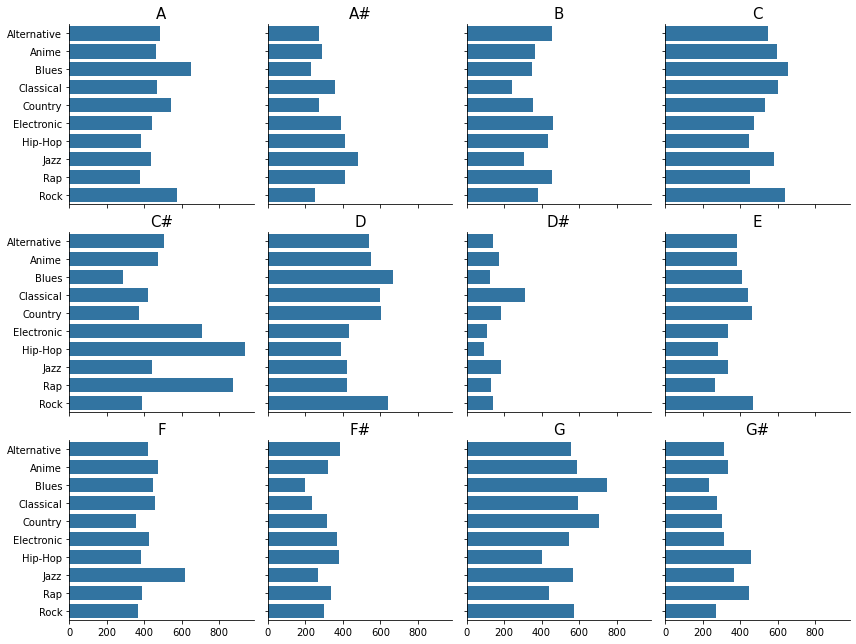

In [17]:
sns.FacetGrid(spotify, col = "key", col_wrap = 4).\
map_dataframe(sns.countplot, y = "music_genre").\
set_titles(col_template = "{col_name}", size = 15)
plt.show()

O gráfico acima mostra a distribuição dos gêneros em cada clave (key). Podemos perceber, por exemplo, que os gêneros mais frequentes na clave C# são Hip-Hop, Rap e Eletronic. Essa análise é importante, pois temos uma ideia de quais gêneros estão mais presentes em cada clave. Quanto mais associada uma clave está a um gênero, mais contribuição a clave terá na classificação do gênero musical.

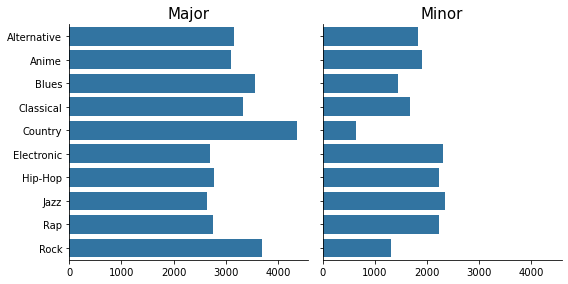

In [18]:
sns.FacetGrid(spotify, col = "mode", height = 4, aspect = 1).\
map_dataframe(sns.countplot, y = "music_genre").\
set_titles(col_template = "{col_name}", size = 15)
plt.show()

O gráfico acima mostra a distribuição dos gêneros em cada categoria da feature mode. De todos os gêneros, mode é mais adequado para classificar Country, pois mode traz maior separabilidade para esse gênero.

### Análise das preditoras numéricas versus variável resposta

In [19]:
def boxplot(feature):
    sns.boxplot(data = spotify, x = feature, y = "music_genre")
    plt.xlabel(feature, size = 12.5)
    plt.ylabel("")

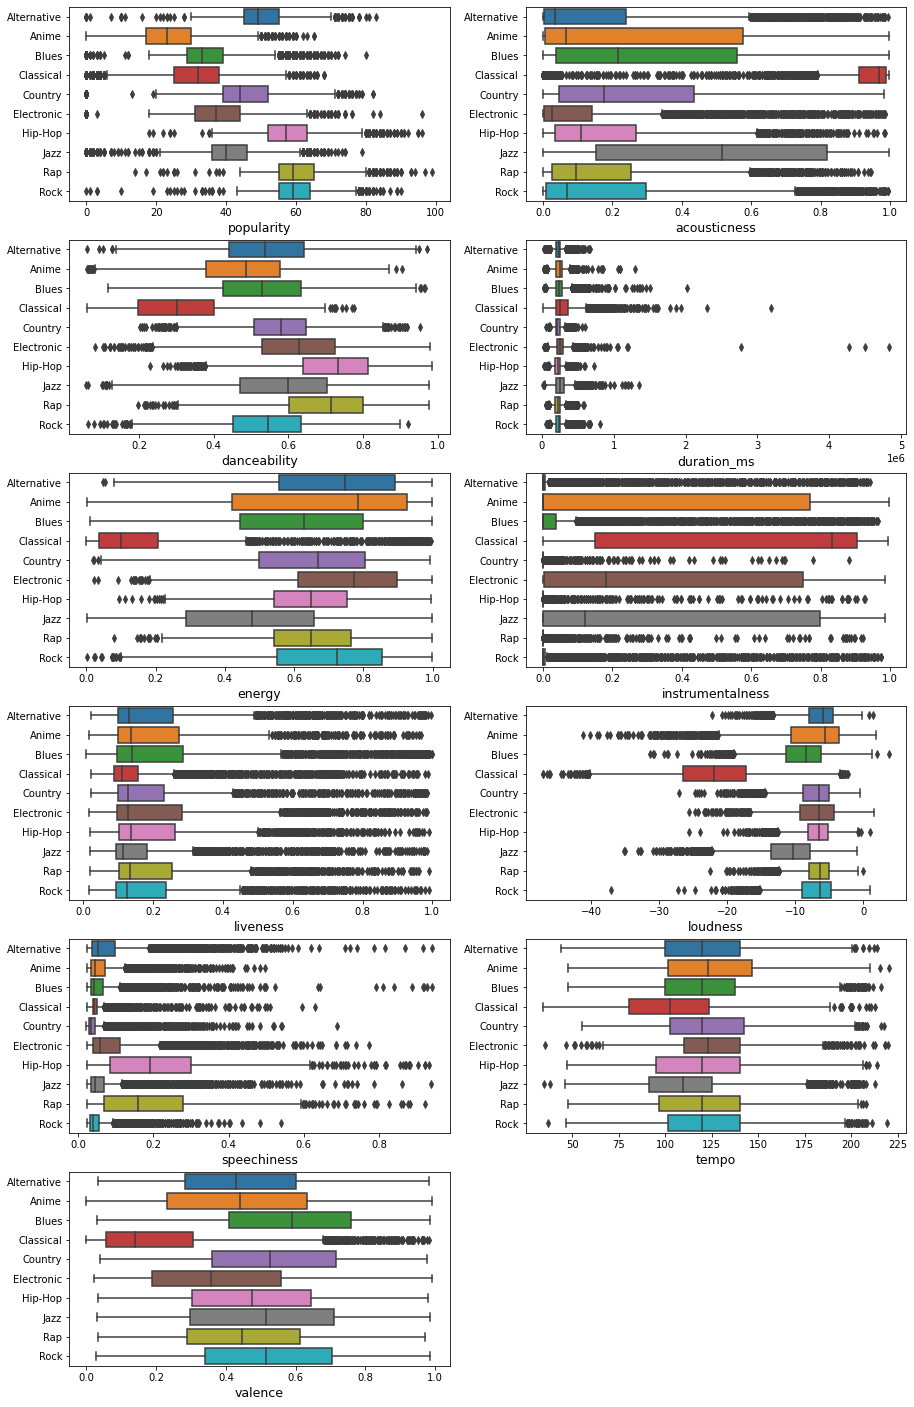

In [20]:
f = plt.figure(figsize = (15, 25))
gs = f.add_gridspec(6, 2)

f.add_subplot(gs[0, 0])
boxplot("popularity")

f.add_subplot(gs[0, 1])
boxplot("acousticness")

f.add_subplot(gs[1, 0])
boxplot("danceability")

f.add_subplot(gs[1, 1])
boxplot("duration_ms")

f.add_subplot(gs[2, 0])
boxplot("energy")

f.add_subplot(gs[2, 1])
boxplot("instrumentalness")

f.add_subplot(gs[3, 0])
boxplot("liveness")

f.add_subplot(gs[3, 1])
boxplot("loudness")

f.add_subplot(gs[4, 0])
boxplot("speechiness")

f.add_subplot(gs[4, 1])
boxplot("tempo")

f.add_subplot(gs[5, 0])
boxplot("valence")

plt.show()

Os boxplots acima mostram a distribuição das preditoras numuméricas em cada gênero musical. Algumas preditoras conseguem diferenciar mais os genêros do que outras. Por exemplo, a preditora acousticness diferencia mais os gêneros do que a preditora tempo, e isso sugere que acousticness contribuirá mais para o modelo de classificação.

Embora tenham muitos pontos que são considerados outliers, não fazemos nenhum tratamento para outlier, pois, como temos dezenas de milhares de registros, é esperado que tenhamos pontos fora dos limites do boxplot.

# Pré-processamento

O pré-processamento será feito de acordo com o modelo escolhido. Por exemplo, um modelo baseado em distâncias requer preditoras numéricas na mesma escala, enquanto que uma árvore de decisão não precisa que as preditoras numéricas estejam na mesma escala.

A ideia é cada integrante do grupo propor um modelo e no final avaliamos os modelos para ver qual tem melhor desempenho na classificação dos gêneros musicais. Uma cópia do data.frame **spotify** é feita para cada integrante e, com isso, cada integrante fará um pré-processamento na sua cópia da tabela original de acordo com o modelo que escolheu. 

# Modelagem

### Modelo Claudio

In [21]:
spotify_c = spotify.copy()

### Modelo Fabio

In [22]:
spotify_f = spotify.copy()

### Modelo Mateus

In [23]:
spotify_mtz = spotify.copy()

In [24]:
## Separando dados e rótulos (X/Y)

Y = spotify_mtz['music_genre']
X = spotify_mtz.drop('music_genre', axis = 1)

A princípio eu queria aplicar uma árvore de decisão, mas esse método tem grande variabilidade. Isso quer dizer que a árvore é bastante sensível ao conjunto de treino selecionado, onde dois conjuntos de treinos diferentes fornecem duas árvores diferentes. Pensando nisso, vou aplicar uma floresta aleatória. A floresta aleatória não tem a interpretação simples igual uma árvore de decisão, mas tem baixa variabilidade e maior poder de predição.

O tempo de execução de uma floresta aleatória tende a ser bastante demorado para grandes conjuntos de dados. Para otimizar o tempo de execução, vou aplicar PCA nas variáveis numéricas para reduzir a dimensão dos dados.

In [25]:
# Normalizando dados

from sklearn.preprocessing import StandardScaler

x_pca = X.drop(['key', 'mode'], axis = 1)

std_scaler = StandardScaler()
x_norm     = std_scaler.fit_transform(x_pca)
df         = pd.DataFrame(x_norm)

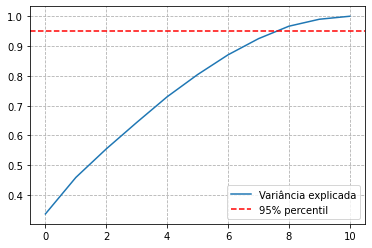

In [26]:
# Aplicando PCA

from sklearn.decomposition import PCA

pca = PCA().fit(x_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label = 'Variância explicada')
plt.axhline(0.95, color = 'red', linestyle = '--', label = '95% percentil')
plt.grid(True, linestyle = '--')
plt.legend()
plt.show()

Como pode ser visto na Figura, com 8 componentes já atingimos uma variância explicada maior que 95%, assim podemos utilizar 8 componentes em nossa modelagem.

In [27]:
pca       = PCA(n_components = 8)
dados_pca = pca.fit_transform(x_norm)

X_preProcessado = pd.DataFrame(data = dados_pca, columns = ["Componente" + str(i) for i in range(1,9)])
X_preProcessado['key'] = X['key']
X_preProcessado['mode'] = X['mode']
X_preProcessado = pd.get_dummies(X_preProcessado, drop_first = True)

In [28]:
# Separação de dados de treino e teste

from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(X_preProcessado, Y, test_size = 0.1, random_state = 99, shuffle = True)

print(f'Quantidade dados treino {len(x_treino)} quantidade de rótulos treino {len(y_treino)}')
print(f'Quantidade dados teste {len(x_teste)} quantidade de rótulos teste {len(y_teste)}')

Quantidade dados treino 45000 quantidade de rótulos treino 45000
Quantidade dados teste 5000 quantidade de rótulos teste 5000


### Treinando Classificador: Floresta Aleatória

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300,
                            criterion = "gini",
                            min_samples_split = 5,
                            random_state = 99)
rf.fit(x_treino, y_treino)

RandomForestClassifier(min_samples_split=5, n_estimators=300, random_state=99)

### Relatório de classificação e matriz de confusão para a árvore de decisão

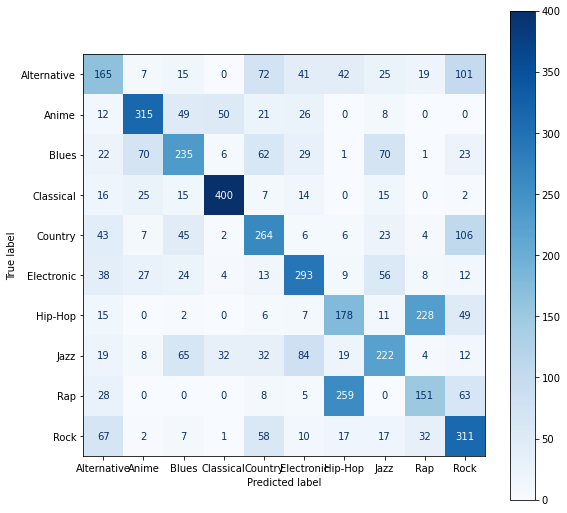

In [30]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize = (9, 9))
disp = plot_confusion_matrix(rf, x_teste, y_teste, cmap = plt.cm.Blues, ax = ax);

Pela matriz de confusão, o algoritmo tem um bom resultado ao prever o gênero anime e classical, mas não performa bem ao prever o gênero alternativo e confunde rap com hip-hop, que são gêneros bem parecidos.

In [31]:
from sklearn.metrics import classification_report

predicoes  = rf.predict(x_teste)

# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_teste, predicoes, zero_division = 0))  

Relatório de classificação: 
               precision    recall  f1-score   support

 Alternative       0.39      0.34      0.36       487
       Anime       0.68      0.65      0.67       481
       Blues       0.51      0.45      0.48       519
   Classical       0.81      0.81      0.81       494
     Country       0.49      0.52      0.50       506
  Electronic       0.57      0.61      0.59       484
     Hip-Hop       0.34      0.36      0.35       496
        Jazz       0.50      0.45      0.47       497
         Rap       0.34      0.29      0.31       514
        Rock       0.46      0.60      0.52       522

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.50      5000



Pelo relatório de classificação, o gênero classical tem melhores resultados. Por outro lado, o hip-hop e o rap tem piores resultados, e isso pode ser resultado do algoritmo confundir esses dois gêneros. No geral, o algoritmo não tem um bom resultado, pois a acurácia é de 0.51.

### Aprimorando os resultados da floresta aleatória

O objetivo aqui é aplicar validação cruzada para testar se um número maior de árvores melhora a acurácia de forma significativa. Não considero quantidade de árvores maiores que 1000, pois o algoritmo demora muito para executar.

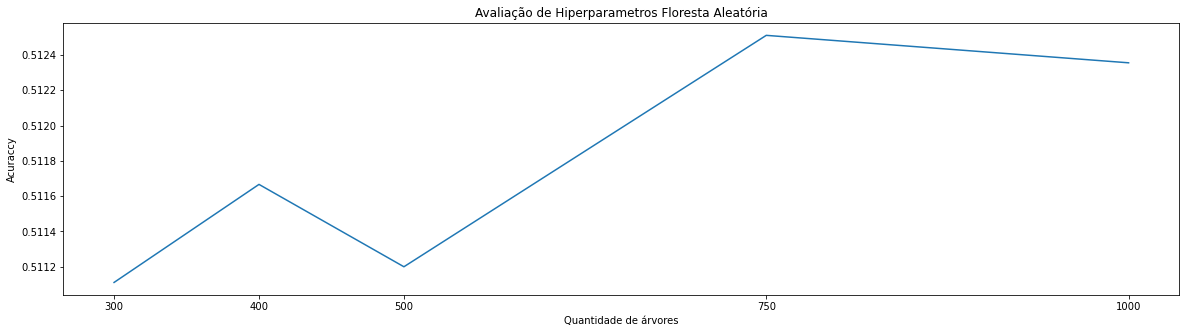

In [32]:
from sklearn.model_selection import cross_val_score

accuracy_list = []
n_tree = [300, 400, 500, 750, 1000]

for n in n_tree:
    rf = RandomForestClassifier(n_estimators = n,
                                criterion = "gini",
                                min_samples_split = 5,
                                random_state = 99)
    # rf.fit(x_treino, y_treino)
    scores = cross_val_score(rf, x_treino, y_treino, cv = 5)
    accuracy_list.append(scores.mean())
    
fig, ax = plt.subplots(figsize = (20, 5))
ax.plot(n_tree, accuracy_list)
ax.set(xlabel = 'Quantidade de árvores', ylabel = 'Acuraccy', title = 'Avaliação de Hiperparametros Floresta Aleatória', xticks = n_tree)
plt.show();

A Figura acima mostra que 750 árvores fornece a maior acurácia. Mesmo assim, o ganho foi ínfimo, pois a acurácia nem alcançou 0.52.

In [33]:
rf = RandomForestClassifier(n_estimators = 750,
                            criterion = "gini",
                            min_samples_split = 5,
                            random_state = 99)
rf.fit(x_treino, y_treino)

RandomForestClassifier(min_samples_split=5, n_estimators=750, random_state=99)

### Importância das variáveis

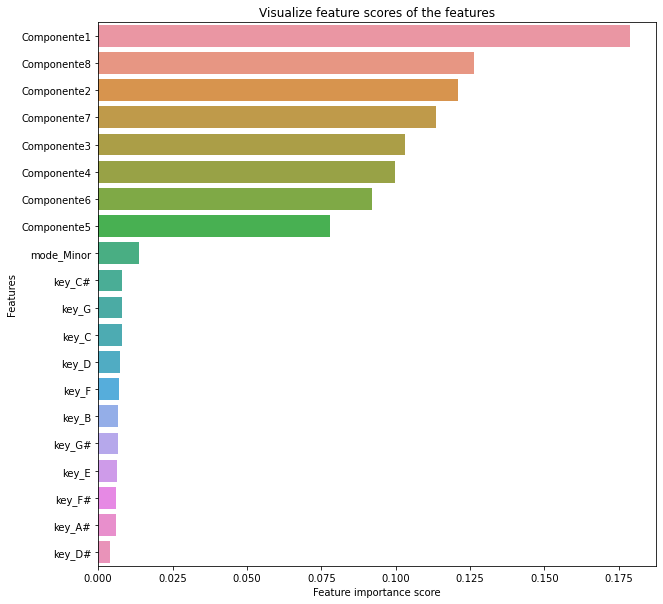

In [39]:
feature_scores = pd.Series(rf.feature_importances_, index = x_treino.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x = feature_scores, y = feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

O gráfico acima mostra as variáveis mais importantes para a classificação dos gêneros. As componentes principais são mais importantes para a tarefa de classificação, enquanto que as variáveis categóricas são menos importantes, sendo a key menos importante.

### Modelo Michael

In [30]:
spotify_mcl = spotify.copy()